# Quantum Amplitude Amplification get Maximum Value
Here we apply the dataset as if they were a percent error of $\pi$ :
- By default a rotation of $\pi$ is apply.
- A data of $10$ implied an error of $10\%$ and so a rotation of $acos(1-(10*2/100))$ gonna be apply instead of $\pi$.

In [1]:
import math
import itertools
import numpy as np
import random

import qiskit
from qiskit import Aer, QuantumCircuit, execute, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram

In [2]:
PG_i = [random.random()*100 for _ in range(2**3)]
len_qram = math.ceil(math.log2(len(PG_i)))
len_val = 5

In [3]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits, name = 'Diffuser')
    for qubit in range(nqubits):
        qc.h(qubit)
    for qubit in range(nqubits):
        qc.x(qubit)
    qc.h(nqubits - 1)
    qc.mct(list(range(nqubits - 1)), nqubits - 1)
    qc.h(nqubits - 1)
    for qubit in range(nqubits):
        qc.x(qubit)
    for qubit in range(nqubits):
        qc.h(qubit)
        
    return qc

In [4]:
def ram(nb_qram, nb_val, data):
    map_ram = list(itertools.product([0, 1], repeat=nb_qram))
    qram = QuantumRegister(nb_qram, 'qram')
    qval = QuantumRegister(nb_val, 'qval')
    qc = QuantumCircuit(qram, qval, name = 'QRAM')
        
    # Map data of the dataset
    for d, m_ram in zip(data, map_ram):

        # Init binary state
        for index, gate in enumerate(m_ram):
            if gate == 0:
                qc.x(qram[index])
        
        # We apply the data of the dataset as a percent error of pi
        for val in qval:
            qc.mcrx(math.acos(1-(d*2/100)), qram, val)
        
        # Close binary state
        for index, gate in enumerate(m_ram):
            if gate == 0:
                qc.x(qram[index])
    
    return qc

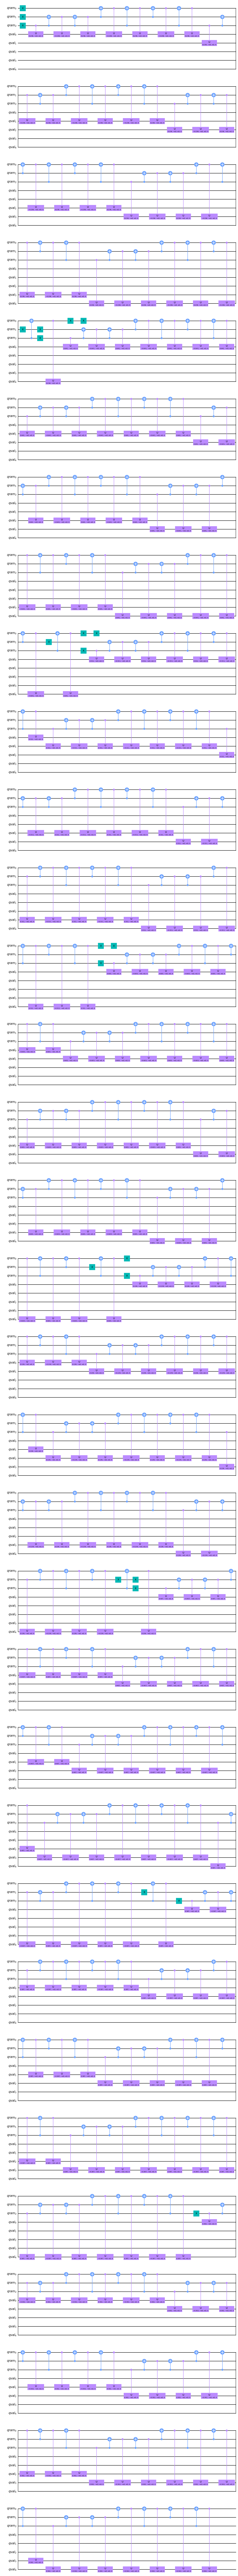

In [5]:
ram(len_qram, len_val, PG_i).draw(output='mpl')

In [6]:
qram = QuantumRegister(len_qram, 'qram')
qval = QuantumRegister(len_val, 'qval')
oracle = QuantumRegister(1, 'oracle')
c = ClassicalRegister(len_qram, 'measurement')

qc = QuantumCircuit(qram, qval, oracle, c)

# Init
qc.h(qram)
qc.x(oracle)
qc.h(oracle)
qc.barrier()

# Qram
qc.append(ram(len_qram, len_val, PG_i), [*[i for i in range(len_qram+len_val)]])
qc.barrier()

# Oracle
qc.mcx(qval, oracle)
qc.barrier()

# Revert Qram
qc.append(ram(len_qram, len_val, PG_i).inverse(),  [*[i for i in range(len_qram+len_val)]])
qc.barrier()

# Diffuser
qc.append(diffuser(len_qram), [*[i for i in range(len_qram)]])

# Measure of the ouputs
qc.barrier()
qc.measure(qram, c)

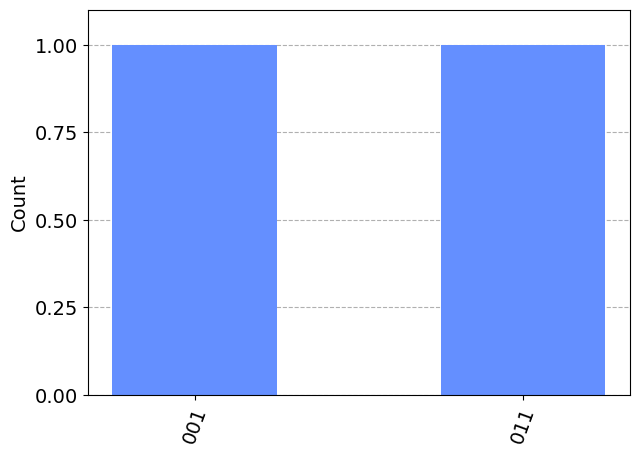

In [7]:
qasm = Aer.get_backend('qasm_simulator')
backend_sim = qasm
qc = qc.reverse_bits()
job = execute(qc, backend_sim, shots=2)
result_job = job.result()
result_count = result_job.get_counts()
plot_histogram(result_count, bar_labels=False)

In [8]:
#Quantum
best_suggestion = PG_i[int(list(result_count.keys())[0], 2)]
second_best_suggestion = PG_i[int(list(result_count.keys())[1], 2)]

#Classical way (we want to replace by the quantum way)
PG_i.sort()
classi_best_suggestion = PG_i[-1]
classi_second_best_suggestion = PG_i[-2]

# Print the result
print('QUANTUM : The two highest purity gains are:', best_suggestion, ' and ', second_best_suggestion)
print('CLASSICAL : The two highest purity gains are:', classi_best_suggestion, ' and ', classi_second_best_suggestion)

QUANTUM : The two highest purity gains are: 87.32855067832949  and  91.897712344348
CLASSICAL : The two highest purity gains are: 91.897712344348  and  87.32855067832949


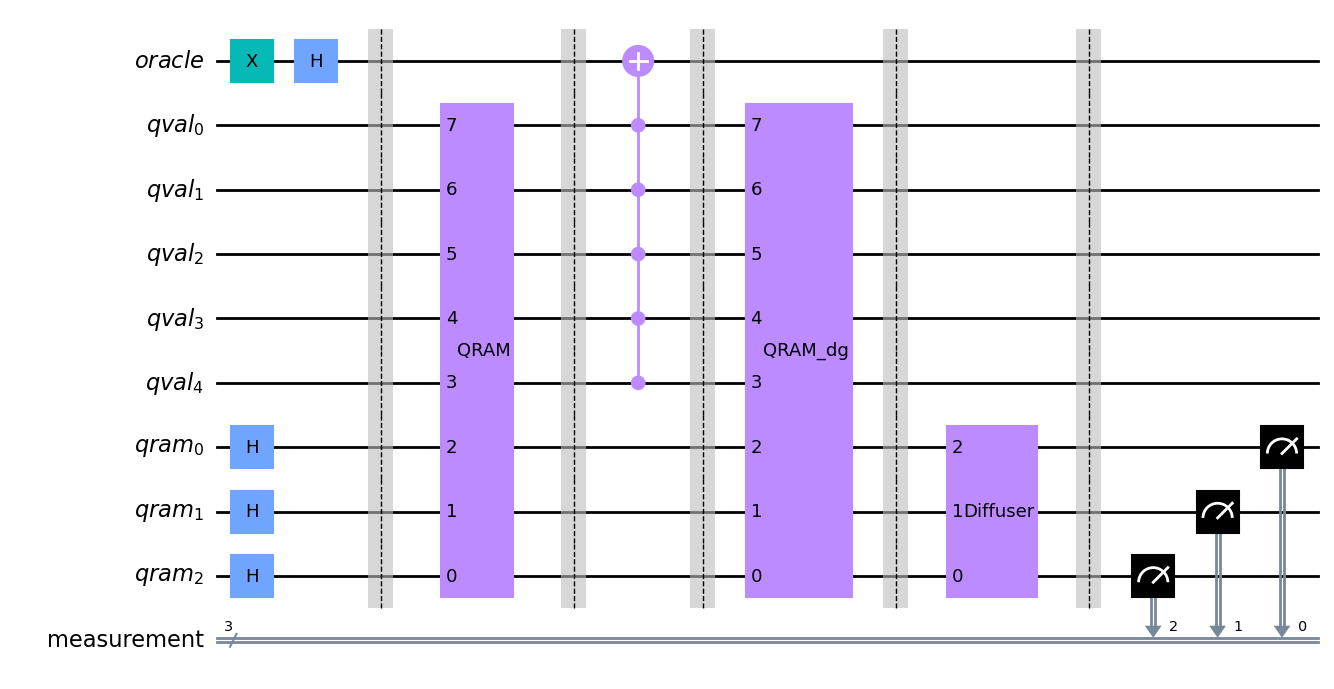

In [9]:
qc.draw(output= 'mpl')

In [10]:
qc.decompose().decompose().decompose().decompose().depth()

3082